In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('imageset_gray_100_75.csv')
print(df.shape)

(1384, 7501)


(-0.5, 99.5, 74.5, -0.5)

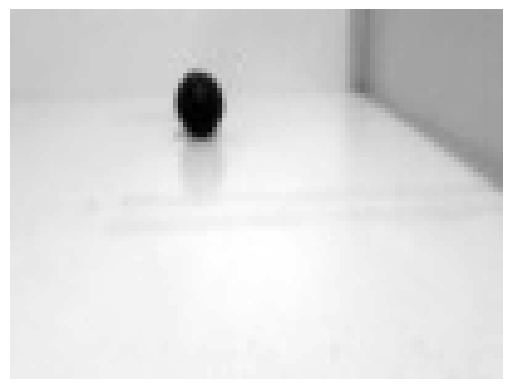

In [3]:
import numpy as np
some_image = df.loc[10,df.columns[:-1]] # type: ignore
some_image_np = some_image.to_numpy()

plt.imshow(np.reshape(some_image_np, (75,100)), cmap='gray')
plt.axis('off')

In [4]:
# problema binario
#X = df.loc[df['y'].isin([0, 1]),:]
#X = X.drop(columns={'y'})
#y = df.loc[df['y'].isin([0, 1]),'y']

#problema multiclasse
X = df.drop(columns={'y'})
y = df['y']


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

### aqui estou usando um SGD, mas pode testar e comparar outros classificadores à vontade, inclusive com pycaret (automl)

In [8]:
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=42, penalty='l1') #se quiser reproduzir os resultados
model_sgd.fit(X_train, y_train)

SGDClassifier(penalty='l1', random_state=42)

In [10]:
# vamos agora usar para detectar imagens com o número alvo
out = model_sgd.predict([some_image])
#print(out)

c:\Users\josen\anaconda3\envs\tadsml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


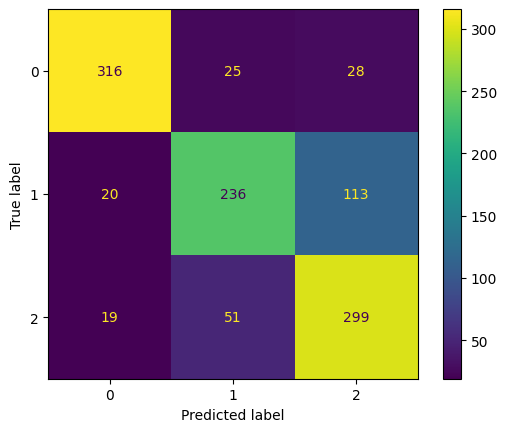

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model_sgd, X_train, y_train, cv=5)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_sgd.classes_)
disp.plot()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       355
           1       0.64      0.76      0.69       312
           2       0.81      0.68      0.74       440

    accuracy                           0.77      1107
   macro avg       0.77      0.78      0.77      1107
weighted avg       0.78      0.77      0.77      1107



              precision    recall  f1-score   support

           0       0.89      0.85      0.87        97
           1       0.71      0.75      0.73        87
           2       0.75      0.75      0.75        93

    accuracy                           0.78       277
   macro avg       0.78      0.78      0.78       277
weighted avg       0.79      0.78      0.78       277



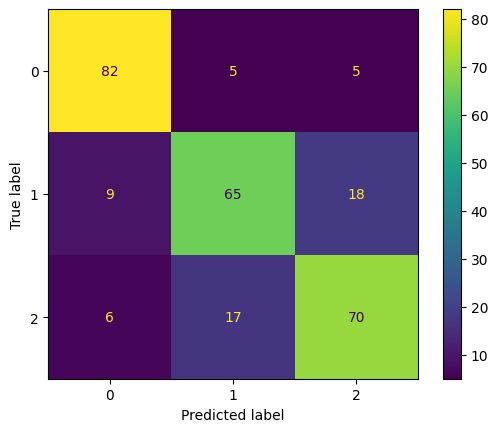

In [13]:
y_test_pred = model_sgd.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_sgd.classes_)
disp.plot()

print(classification_report(y_test_pred, y_test))

In [14]:
import pickle
with open("victim_classifier_bin.pkl", "wb") as f:
    pickle.dump(model_sgd, f)

print("Modelo salvo")

Modelo salvo


#### Faria leitura do modelo para predições

In [15]:
with open('victim_classifier_bin.pkl', "rb") as f:
    model = pickle.load(f)

output = model.predict([some_image])
print(output)

[0]


c:\Users\josen\anaconda3\envs\tadsml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier(random_state=42)

# 3. Definir espaço de busca de hiperparâmetros
param_distributions = {
    "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": [1e-6, 1e-1],   # força da regularização
    "l1_ratio": [0, 1],         # só usado no elasticnet
    "max_iter": [1000, 2000, 3000],
    "learning_rate": ["optimal", "invscaling", "adaptive"],
    "eta0": [1e-4, 1e-1],    # taxa inicial
    "power_t": [0.1, 0.9],      # usado no invscaling
}

# 4. Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_sgd,
    param_distributions=param_distributions,
    n_iter=50,              # número de combinações testadas
    cv=5,                   # cross-validation
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 5. Rodar a busca
random_search.fit(X_train, y_train)

# 6. Melhor combinação encontrada
print("Melhores hiperparâmetros:", random_search.best_params_)
print("Melhor score de validação cruzada:", random_search.best_score_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [11]:
from sklearn.metrics import classification_report
# 7. Avaliar no conjunto de teste
y_pred = random_search.best_estimator_.predict(X_test)
print("\nRelatório de classificação no teste:")
print(classification_report(y_test, y_pred))


Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91        92
           1       0.84      0.70      0.76        92
           2       0.72      0.88      0.79        93

    accuracy                           0.82       277
   macro avg       0.83      0.82      0.82       277
weighted avg       0.83      0.82      0.82       277



In [9]:
import pickle
with open("victim_classifier_100_75.pkl", "wb") as f:
    pickle.dump(random_search.best_estimator_, f)

print("Modelo otimizado salvo")

Modelo otimizado salvo
